In [1]:
import gurobi as gb
import networkx as nx
import matplotlib.pyplot as plt
import random

from networkx import bipartite
from IPython.display import SVG

In [2]:
random.seed(42)

# Generating complete bipartite graph

In [3]:
candidate_location_nb = 5
demand_nb = 30

G = bipartite.random_graph(candidate_location_nb, demand_nb, 1)

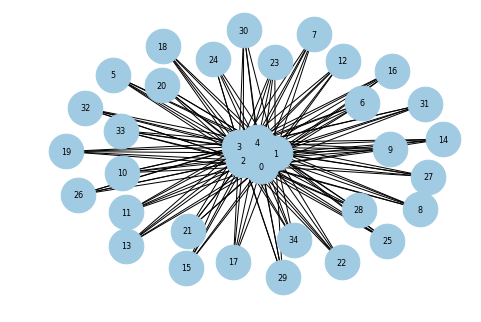

In [4]:
%matplotlib inline
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color='#A0CBE2', width=1, node_size=1200, 
        with_labels=True, hold=None, font_size=8)

In [5]:
c_nodes, d_nodes = bipartite.sets(G)

# Setting the graph attributes for our problem

In [6]:
min_demand = 100
max_demand = 500
demand = {i: random.randint(min_demand, max_demand) for i in d_nodes}
nx.set_node_attributes(G, demand, name="demand")

min_fixed_charge = 1000
max_fixed_charge = 10000
fixed_charge = {i: random.randint(min_fixed_charge, max_fixed_charge) \
                for i in c_nodes}
nx.set_node_attributes(G, fixed_charge, name="fixed charge")

min_distance = 50
max_distance = 100
distance = {(i,j): random.randint(min_distance, max_distance) \
            for i, j in G.edges(c_nodes)}
nx.set_edge_attributes(G, distance, name="distance")

min_D = 60
max_D = 80    
D = {i: random.randint(min_D, max_D) for i in d_nodes}
nx.set_node_attributes(G, D, name="D")

v = random.randint(10, 50)

p = random.randint(1, candidate_location_nb)

In [7]:
def regenerate_node(G, node):
    for (i, j) in G.edges(node):
        distance[(i, j)] = random.randint(min_distance, max_distance)
        G[i][j]["distance"] = distance[(i, j)]
    D[node] = random.randint(min_D, max_D)
    G.nodes[node]["D"] = D[node]

In [8]:
G.nodes(data=True)

NodeDataView({0: {'bipartite': 0, 'fixed charge': 7873}, 1: {'bipartite': 0, 'fixed charge': 4611}, 2: {'bipartite': 0, 'fixed charge': 8359}, 3: {'bipartite': 0, 'fixed charge': 5557}, 4: {'bipartite': 0, 'fixed charge': 1106}, 5: {'bipartite': 1, 'demand': 427, 'D': 65}, 6: {'bipartite': 1, 'demand': 157, 'D': 76}, 7: {'bipartite': 1, 'demand': 112, 'D': 63}, 8: {'bipartite': 1, 'demand': 479, 'D': 80}, 9: {'bipartite': 1, 'demand': 240, 'D': 69}, 10: {'bipartite': 1, 'demand': 225, 'D': 80}, 11: {'bipartite': 1, 'demand': 214, 'D': 76}, 12: {'bipartite': 1, 'demand': 171, 'D': 79}, 13: {'bipartite': 1, 'demand': 477, 'D': 66}, 14: {'bipartite': 1, 'demand': 152, 'D': 64}, 15: {'bipartite': 1, 'demand': 446, 'D': 71}, 16: {'bipartite': 1, 'demand': 479, 'D': 65}, 17: {'bipartite': 1, 'demand': 379, 'D': 77}, 18: {'bipartite': 1, 'demand': 144, 'D': 76}, 19: {'bipartite': 1, 'demand': 402, 'D': 60}, 20: {'bipartite': 1, 'demand': 316, 'D': 79}, 21: {'bipartite': 1, 'demand': 116, 'D':

In [9]:
G.edges(data=True)

EdgeDataView([(0, 5, {'distance': 98}), (0, 6, {'distance': 60}), (0, 7, {'distance': 94}), (0, 8, {'distance': 77}), (0, 9, {'distance': 71}), (0, 10, {'distance': 67}), (0, 11, {'distance': 59}), (0, 12, {'distance': 63}), (0, 13, {'distance': 98}), (0, 14, {'distance': 71}), (0, 15, {'distance': 56}), (0, 16, {'distance': 55}), (0, 17, {'distance': 74}), (0, 18, {'distance': 56}), (0, 19, {'distance': 72}), (0, 20, {'distance': 72}), (0, 21, {'distance': 88}), (0, 22, {'distance': 66}), (0, 23, {'distance': 52}), (0, 24, {'distance': 96}), (0, 25, {'distance': 79}), (0, 26, {'distance': 84}), (0, 27, {'distance': 57}), (0, 28, {'distance': 74}), (0, 29, {'distance': 55}), (0, 30, {'distance': 85}), (0, 31, {'distance': 68}), (0, 32, {'distance': 90}), (0, 33, {'distance': 89}), (0, 34, {'distance': 73}), (1, 5, {'distance': 86}), (1, 6, {'distance': 62}), (1, 7, {'distance': 95}), (1, 8, {'distance': 54}), (1, 9, {'distance': 52}), (1, 10, {'distance': 92}), (1, 11, {'distance': 64}

# Checking if the graph is correct
Here we need to check if all demand nodes have at least one edge where the distance is less than the maximum distance.<br\>
If a node does not correspond to this constraint, we regenerate all the random numbers concerning the distance for this node

In [10]:
for node in d_nodes:
    min_d = max_demand
    while min_d > G.nodes[node]["D"]:
        for (i, j) in G.edges(node):
            min_d = G[i][j]["distance"] if G[i][j]["distance"] < min_d else min_d
        
        print("Node", node, "min_d", min_d, "D", G.nodes[node]["D"])
        if min_d > G.nodes[node]["D"]:
            print("Regeneration of node",node)
            regenerate_node(G, node)
            min_d = max_demand
        print()
        

Node 5 min_d 84 D 65
Regeneration of node 5

Node 5 min_d 58 D 68

Node 6 min_d 54 D 76

Node 7 min_d 59 D 63

Node 8 min_d 54 D 80

Node 9 min_d 52 D 69

Node 10 min_d 65 D 80

Node 11 min_d 59 D 76

Node 12 min_d 63 D 79

Node 13 min_d 68 D 66
Regeneration of node 13

Node 13 min_d 63 D 66

Node 14 min_d 50 D 64

Node 15 min_d 56 D 71

Node 16 min_d 55 D 65

Node 17 min_d 57 D 77

Node 18 min_d 56 D 76

Node 19 min_d 72 D 60
Regeneration of node 19

Node 19 min_d 69 D 71

Node 20 min_d 53 D 79

Node 21 min_d 64 D 70

Node 22 min_d 52 D 75

Node 23 min_d 52 D 60

Node 24 min_d 71 D 63
Regeneration of node 24

Node 24 min_d 57 D 67

Node 25 min_d 55 D 71

Node 26 min_d 54 D 69

Node 27 min_d 53 D 67

Node 28 min_d 57 D 61

Node 29 min_d 55 D 67

Node 30 min_d 50 D 78

Node 31 min_d 54 D 62

Node 32 min_d 88 D 62
Regeneration of node 32

Node 32 min_d 51 D 67

Node 33 min_d 66 D 75

Node 34 min_d 60 D 62



In [11]:
hcf = gb.Model()

In [12]:
# Variable definition
x = hcf.addVars(c_nodes, vtype=gb.GRB.BINARY, name="x")
y = hcf.addVars(G.edges(c_nodes), obj=[G[u][v]['distance'] for u,v in G.edges()], vtype=gb.GRB.BINARY, name="y")

In [14]:
y

{(0, 5): <gurobi.Var *Awaiting Model Update*>,
 (0, 6): <gurobi.Var *Awaiting Model Update*>,
 (0, 7): <gurobi.Var *Awaiting Model Update*>,
 (0, 8): <gurobi.Var *Awaiting Model Update*>,
 (0, 9): <gurobi.Var *Awaiting Model Update*>,
 (0, 10): <gurobi.Var *Awaiting Model Update*>,
 (0, 11): <gurobi.Var *Awaiting Model Update*>,
 (0, 12): <gurobi.Var *Awaiting Model Update*>,
 (0, 13): <gurobi.Var *Awaiting Model Update*>,
 (0, 14): <gurobi.Var *Awaiting Model Update*>,
 (0, 15): <gurobi.Var *Awaiting Model Update*>,
 (0, 16): <gurobi.Var *Awaiting Model Update*>,
 (0, 17): <gurobi.Var *Awaiting Model Update*>,
 (0, 18): <gurobi.Var *Awaiting Model Update*>,
 (0, 19): <gurobi.Var *Awaiting Model Update*>,
 (0, 20): <gurobi.Var *Awaiting Model Update*>,
 (0, 21): <gurobi.Var *Awaiting Model Update*>,
 (0, 22): <gurobi.Var *Awaiting Model Update*>,
 (0, 23): <gurobi.Var *Awaiting Model Update*>,
 (0, 24): <gurobi.Var *Awaiting Model Update*>,
 (0, 25): <gurobi.Var *Awaiting Model Update*

In [14]:
# Every demand node should be linked to an established facility
N = {i:[j for _, j in G.edges(i) if G[i][j]["distance"] < G.nodes[i]["D"]]\
      for i in d_nodes}

hcf.addConstr(x.sum() == p, name="FacilityNb")
hcf.addConstrs((x.sum(N[i]) >= z[i] for i in d_nodes), name="Covering")
hcf.update()
hcf.write('hcf3.lp')

In [15]:
hcf.optimize()

Optimize a model with 31 rows, 35 columns and 106 nonzeros
Variable types: 0 continuous, 35 integer (35 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 5820.0000000
Presolve removed 18 rows and 18 columns
Presolve time: 0.00s
Presolved: 13 rows, 17 columns, 45 nonzeros
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: objective 7.347500e+03, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7347.50000    0    6 5820.00000 7347.50000  26.2%     -    0s
H    0     0                    6755.0000000 7347.50000  8.77%     -    0s
H    0     0                    6784.0000000 7347.50000  8.31%     -    0s
H    0     0                    6880.0000000 7347.50000  6.80%     -    0s

# Solution Drawing

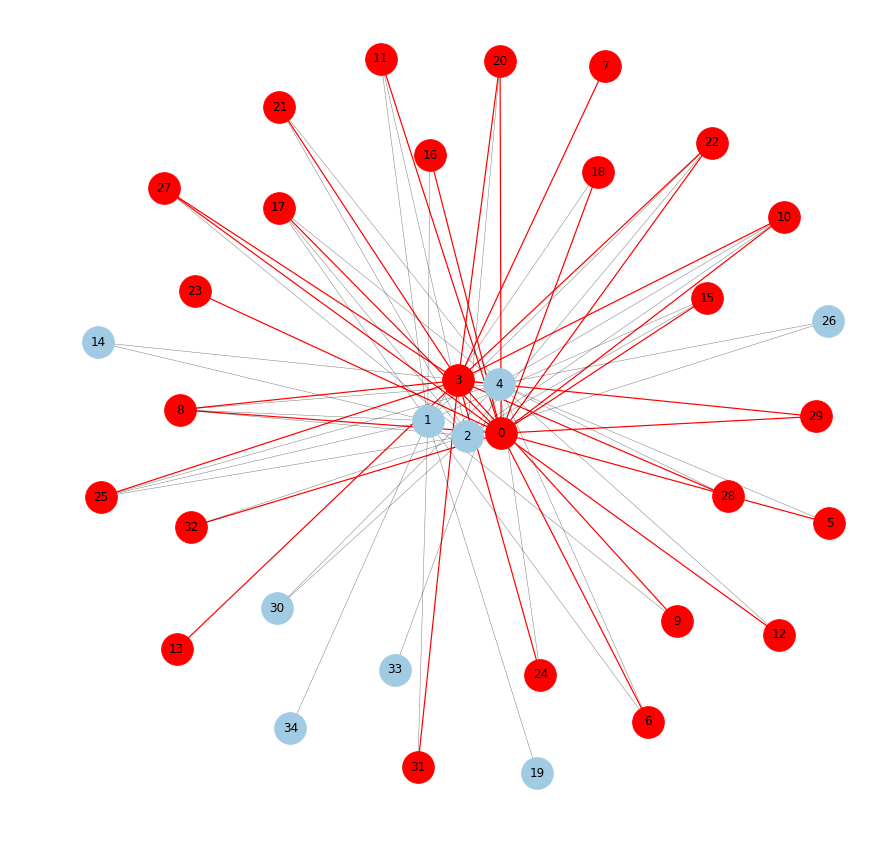

In [16]:
%matplotlib inline
plt.figure(figsize=(demand_nb // 2, demand_nb // 2))

pos = nx.spring_layout(G)

activated_edge = [(i, j) for i in d_nodes for j in N[i] if x[j].x > 0 and z[i].x > 0]
not_activated_edge = [(i, j) for i in d_nodes for j in N[i] if x[j].x <= 0 or z[i].x <= 0]

nx.draw_networkx_edges (G, pos, edgelist=activated_edge, edge_color='r', width = 1.2)
nx.draw_networkx_edges (G, pos, edgelist=not_activated_edge, edge_color='black', width=0.5, alpha = 0.5)

nodelab = {i:i for i in G.nodes()}

active_facility = [i for i in c_nodes if x[i].x > 0]
not_active_facility = [i for i in c_nodes if x[i].x <= 0]
active_demand = [i for i in d_nodes if z[i].x > 0]
not_active_demand = [i for i in d_nodes if z[i].x <= 0]

nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=1000, nodelist=active_facility + active_demand, node_color ='r')
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=1000, nodelist=not_active_facility + not_active_demand, node_color ='#A0CBE2')

nx.draw_networkx_labels(G, pos, labels=nodelab);
nx.draw(G, pos, with_labels=True,  alpha=0.0, node_color ='b', node_size=500, nodelabels=nodelab)
